# Individual Conditional Expectation (ICE) Plots

 - ICE plots can show how the model's predictions vary for individual data points.
 - This granularity allows us to uncover cases where the model predicts both high and low values for different samples, which might not be readily apparent in PDPs that show only average effects.
</br>

 - Generating ICE plots is easy, we change only one plot parameter in both APIs provided by scikit-learn and PDPBox.

In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [32]:
from feature_engine.encoding import OneHotEncoder

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [34]:
from xgboost import XGBClassifier

### Load Titanic data

In [307]:
# The data can be accessed online.
data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

In [6]:
data.shape

(1309, 14)

In [7]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


### Preprocess data

 - Please note that it's important to split the data before pre-processing, which is not the case here.

In [8]:
# Replace question mark by NaN
data = data.replace('?', np.nan)


# Extract the first letter from the variable cabin
def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)


# capture letter from cabin
data["cabin"] = data["cabin"].str[0]

# cabin T is a rare label, we replace it with G
data.loc[data["cabin"] == "T", "cabin"] = "G"

# impute cabin and embarked
data.fillna({
    "cabin":"M",
    "embarked": "S",
}, inplace=True)

# set pclass', 'sibsp', 'parch' columns to data type int
data[['pclass', 'sibsp', 'parch']] = data[['pclass', 'sibsp', 'parch']].astype(int)

# set fare to data type float
data['fare'] = data['fare'].astype(float)
# impute fare with the median
data['fare'] = data['fare'].fillna(data['fare'].median())

# select the features of interest only
usecols = ["pclass", "sibsp", "parch", "sex", "fare", "embarked", "cabin", "survived", ]
data = data[usecols]

# OHE for categorical features
data = OneHotEncoder(drop_last=False).fit_transform(data)

### Split Data

In [9]:
X = data.drop(columns='survived')
y = data['survived']

In [10]:
X.shape, y.shape

((1309, 17), (1309,))

In [11]:
# separate into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


In [12]:
X_train.shape, X_test.shape

((916, 17), (393, 17))

In [13]:
y_train.shape, y_test.shape

((916,), (393,))

### Train XGBOOST

In [14]:
# create xgboost classifier
xgbc = XGBClassifier(n_estimators=10,
                     max_depth=1,
                     random_state=3,)

# train xgboost
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=3, ...)

In [15]:
# predict to get the model performance
y_train_proba = xgbc.predict_proba(X_train)[:, 1]
y_test_proba = xgbc.predict_proba(X_test)[:, 1]

In [16]:
# train roc-auc
roc_auc_score(y_train, y_train_proba)

0.8301767645001736

In [17]:
# test roc-auc
roc_auc_score(y_test, y_test_proba)

0.8240556385155688

### XGBoost Feature Importance

 XGboost provides feature importance which can be used as a gloabal interpretation method


In [18]:
pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sex_female    0.548961
cabin_M       0.228459
pclass        0.155400
embarked_C    0.067179
cabin_C       0.000000
cabin_G       0.000000
cabin_A       0.000000
cabin_D       0.000000
cabin_E       0.000000
embarked_Q    0.000000
cabin_B       0.000000
sibsp         0.000000
embarked_S    0.000000
sex_male      0.000000
fare          0.000000
parch         0.000000
cabin_F       0.000000
dtype: float32

 - While this intrinsic Feature Importance method is a very useful interpretation method, that uncovers the most impactful features on the model prediction, it cannot show the relationship of a given feature with the target variable, for example:
     - Does the output of a model increase or decrease when a feature increase?
     - What is the nature of the relationship with the target? linear, non-linear, monotonic etc.
     - PDP tries to answer these questions by plotting the feature values on the x-axis and the model outputs on the y-axis

### ICE Plot with PDPBox

In [19]:
from pdpbox import pdp

#### PDP for Gender

In [35]:
# everything stays the same

# create a PDP analysis for sex_female
pdp_sex_female = pdp.PDPIsolate(
    model=xgbc, # specify the trained model here
    df=pd.concat([X_test, y_test], axis=1), # we give PDPIsolate the test data: features and target in the same frame
    model_features=X_test.columns, # here, we provide the names of the features used to train the model
    feature="sex_female", # we select the feature of interest, in this example it is sex_female
    feature_name="gender", # we can set a custom name for the target feature, we go with gender for instance.
)

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

 - PDPIsolate documentation link: https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html

#### Basic plot for Gender

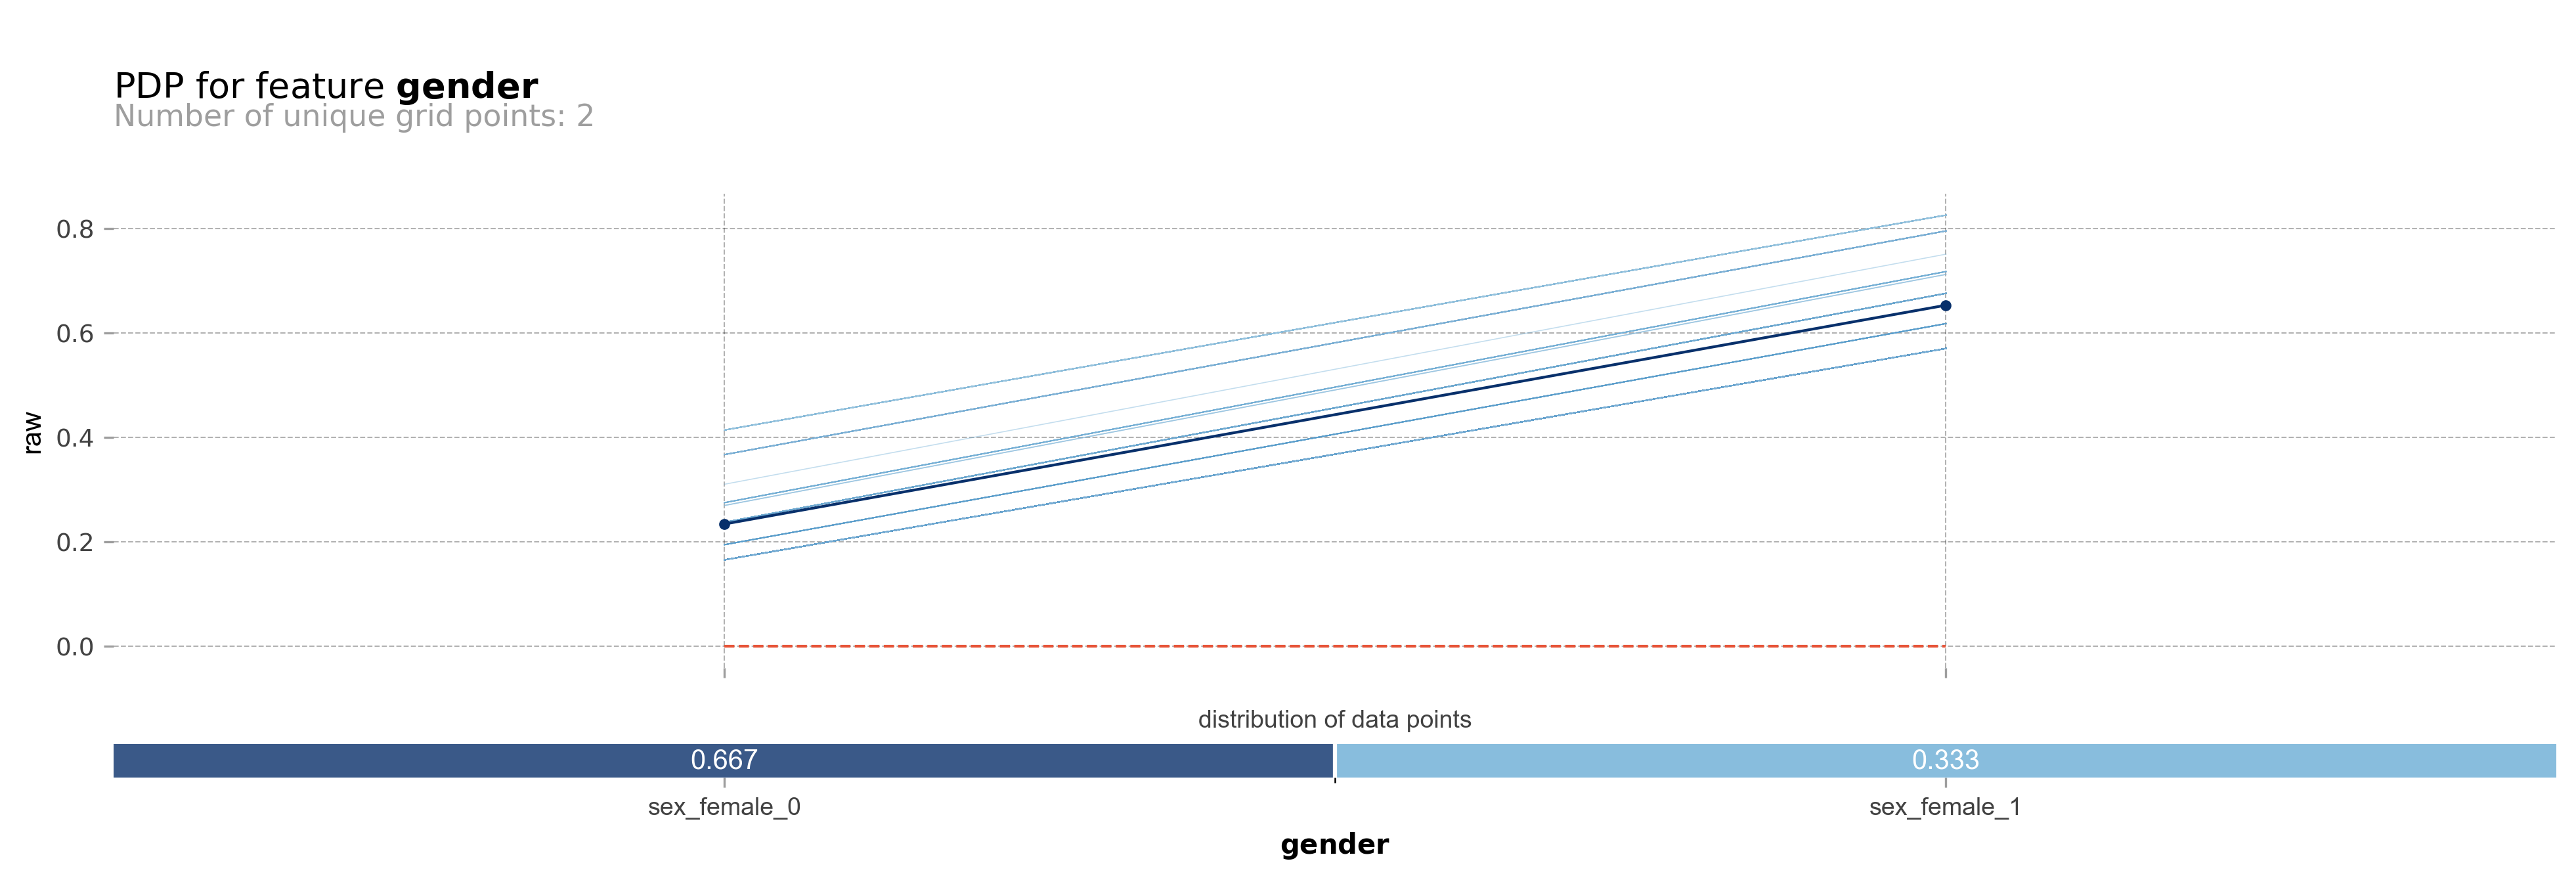

In [37]:
fig, axes = pdp_sex_female.plot(
    center=False,
    plot_lines=True, # set this to True to obtain the ICE instead of the PDP
    plot_pts_dist=True,
    to_bins=False,
    engine='matplotlib',
);

fig.set_figheight(5)

 - We can see how other samples are plotted
 - each line in the plot is a different sample
 - The bold line is the average or the PDP

### ICE for One Hot Encoded feature (cabin)

In [38]:
# get all One Hot Encoded features for cabin
# this list will then be used by PDPbox
cabin_features = sorted([c for c in X_test if c.startswith('cabin_')])

In [39]:
cabin_features

['cabin_A',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_G',
 'cabin_M']

In [40]:
pdp_cabin = pdp.PDPIsolate(
    model=xgbc,
    df=pd.concat([X_test, y_test], axis=1),
    model_features=X_test.columns,
    feature=cabin_features, # we set all the OHE features that correspond to cabin here
    feature_name="cabin", # we can set the name of the main variable here (before pre-processing)
)

obtain pred_func from the provided model.


  0%|          | 0/8 [00:00<?, ?it/s]

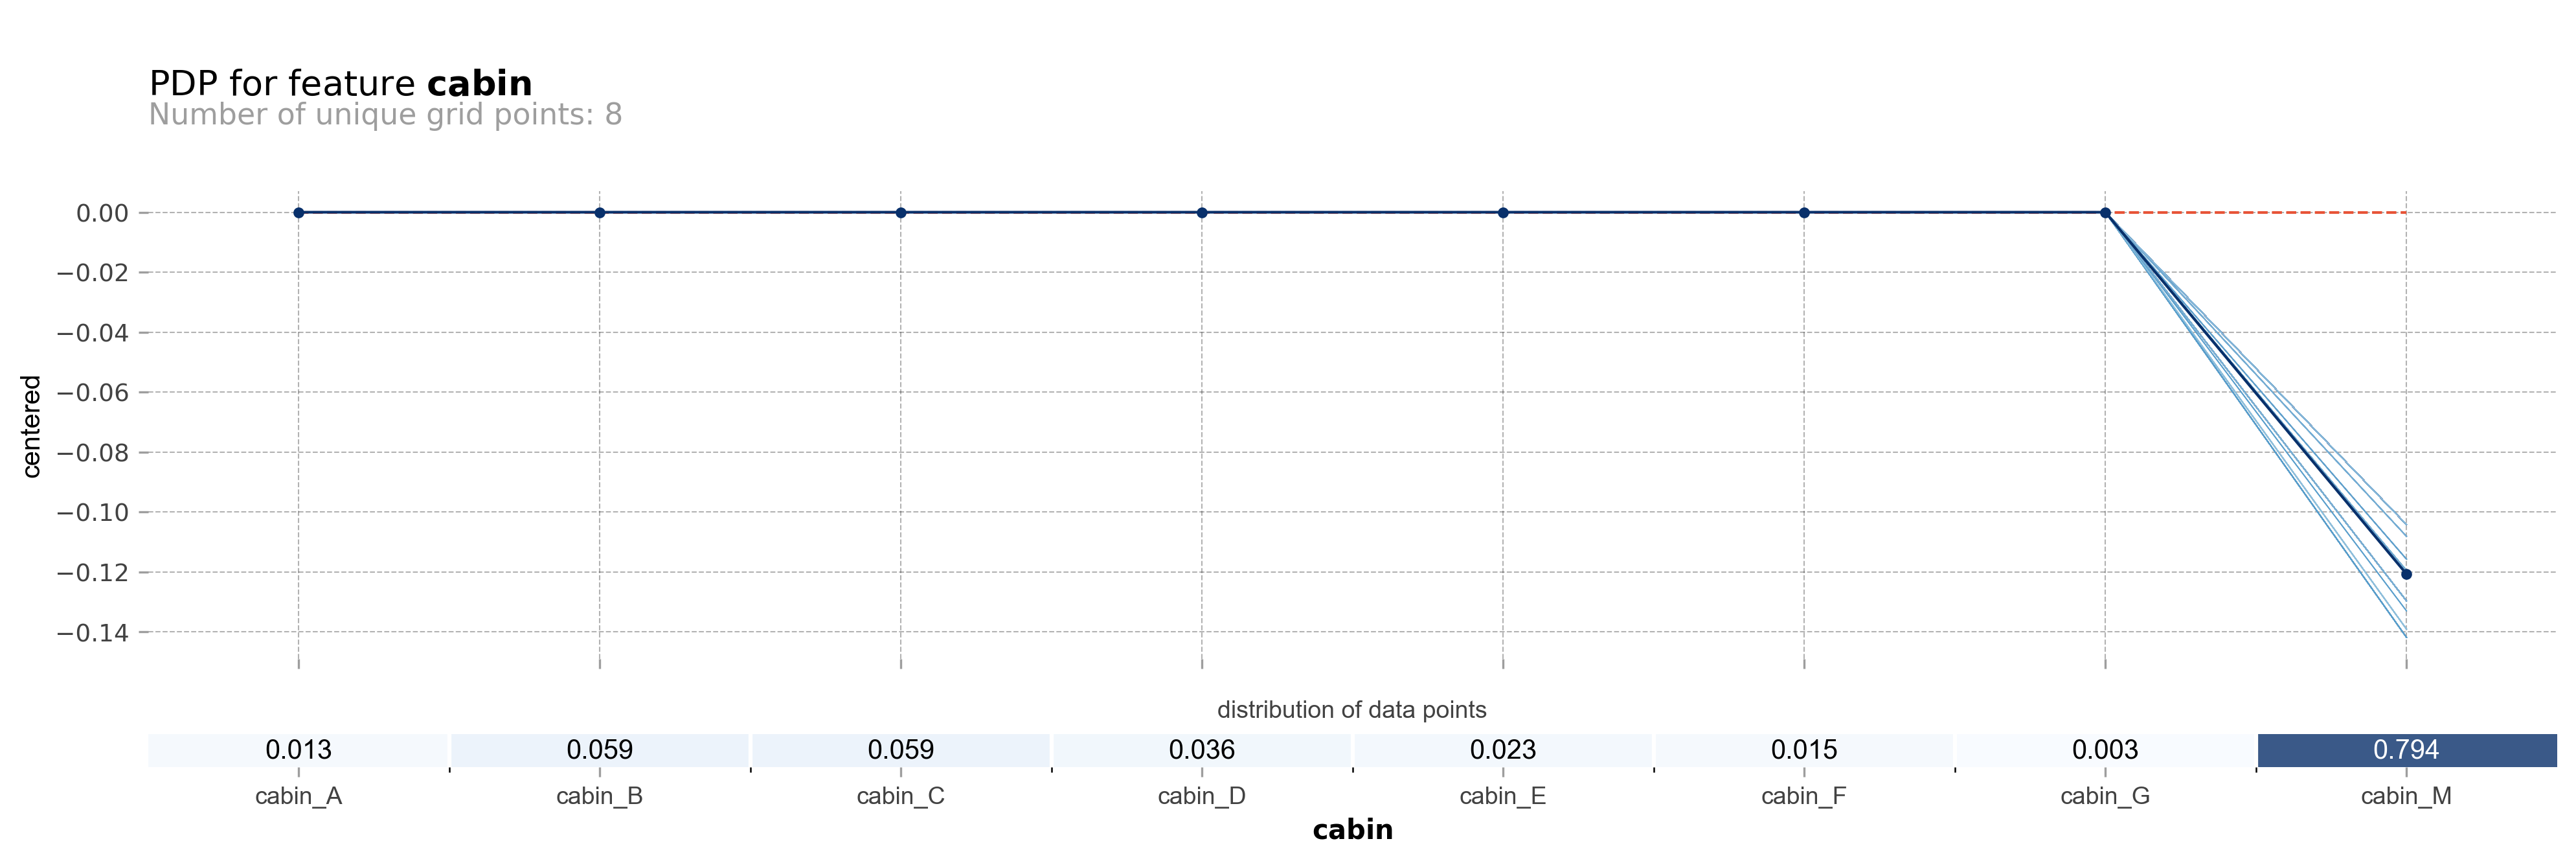

In [41]:
fig, axes = pdp_cabin.plot(
    center=True,
    plot_lines=True, # set this to True
    plot_pts_dist=True, 
    to_bins=False,
    engine='matplotlib',
);
fig.set_figheight(5)

 - In the above, we can see how different samples with cabin_M can have different probabilities.
 - These probabilities can range from -0.10 (10% less chances of Survival) to -0.14 (14% less chances of Survival)
 - We can also see how their mean is the bold line and have a value around 12%

### ICE plots with scikit-learn

In [42]:
from sklearn.inspection import PartialDependenceDisplay

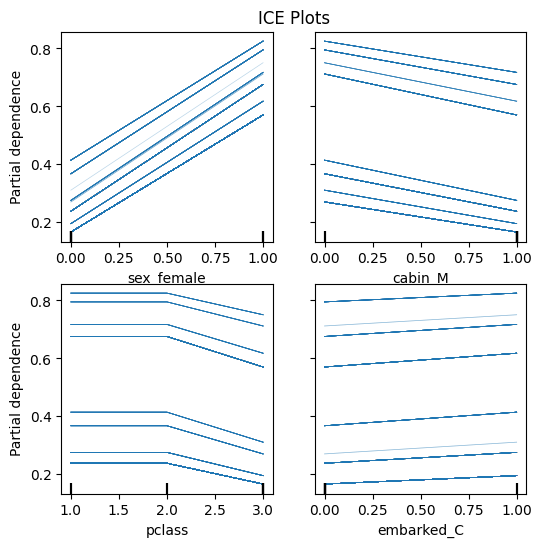

In [45]:
# plot PDP for the 4 important features (from xgboost feature importance)
important_features = ['sex_female', 'cabin_M', 'pclass', 'embarked_C']

fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(xgbc,
                                        X_test,
                                        important_features,
                                        n_cols=2,
                                        ax=ax,
                                        kind='individual'); # we set the kind parameter to individual, the default is average i.e. PDP.
ax.set_title('ICE Plots')
plt.show()


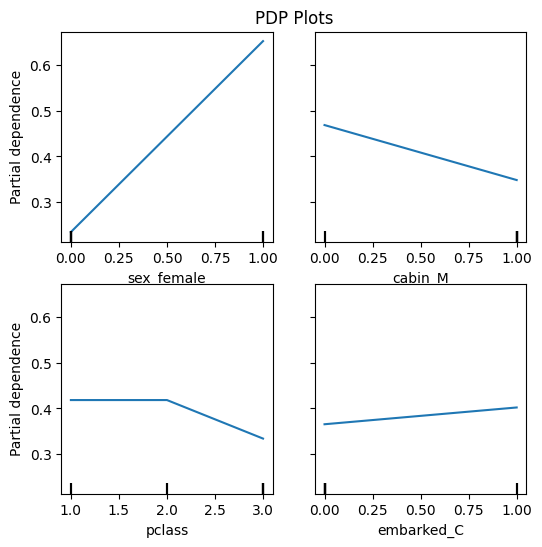

In [47]:
# re-generate the PDP to highlight some differences with the ICE plots
fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(xgbc,
                                        X_test,
                                        important_features,
                                        n_cols=2,
                                        ax=ax,
                                        kind='average'); # we set the kind parameter to individual, the default is average i.e. PDP.
ax.set_title('PDP Plots')
plt.show()

 - When comparing the PDP and ICE for the 'pclass' feature (bottom left plots in the 2 above figures), we can discern the following distinctions:
    - The PDP primarily provides an overview of the general differences between class 3 and the other classes.
    - The ICE plots reveal more nuanced insights. They not only confirm the class-level disparity but also highlight the variability within class 3. Some individual samples in class 3 exhibit notably high outputs, with probabilities reaching around 80%, while others display much lower outputs, with probabilities as low as 0.1%. This level of detail allows for a finer-grained understanding of the feature's impact on model predictions.